In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [2]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()



In [3]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K

def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/((L-1)*L)
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

# Function to plot covariance matrix as an ellipse
def plot_covariance_matrix(ax, center, covariance, chi2_val, edgecolor='blue', alpha=0.5, n_std = 1 ):
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues * chi2_val)  
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, edgecolor=edgecolor, fc=edgecolor, alpha=alpha)
    return ellipse

In [4]:
def Q_tot_3data(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, num_samples=int(1e5)):

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    #r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3


    # Compute some statistic values:
    R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
    R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
    R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
    R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

    samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
    samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
    samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)

    samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
    samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
    samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0

    R_samples_H0_123 = np.zeros(num_samples)
    R_samples_H0_126 = np.zeros(num_samples)
    R_samples_H0_153 = np.zeros(num_samples)
    R_samples_H0_156 = np.zeros(num_samples)
    for i in range(len(R_samples_H0_123)):
        r_1_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (samps_delta_theta_AB_H0[i,:]))
        r_2_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (samps_delta_theta_AC_H0[i,:]))
        r_3_H0 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (samps_delta_theta_BC_H0[i,:]))
        #r_4_H0 = - r_1_H0
        r_5_H0 = - r_2_H0
        r_6_H0 = - r_3_H0

        vectors_H0_123 = np.array([r_1_H0, r_2_H0, r_3_H0])
        R_CM_H0_123 = calculate_R_CM(vectors_H0_123)
        R_samples_H0_123[i] = np.linalg.norm(R_CM_H0_123)**2

        vectors_H0_126 = np.array([r_1_H0, r_2_H0, r_6_H0])
        R_CM_H0_126 = calculate_R_CM(vectors_H0_126)
        R_samples_H0_126[i] = np.linalg.norm(R_CM_H0_126)**2

        vectors_H0_153 = np.array([r_1_H0, r_5_H0, r_3_H0])
        R_CM_H0_153 = calculate_R_CM(vectors_H0_153)
        R_samples_H0_153[i] = np.linalg.norm(R_CM_H0_153)**2

        vectors_H0_156 = np.array([r_1_H0, r_5_H0, r_6_H0])
        R_CM_H0_156 = calculate_R_CM(vectors_H0_156)
        R_samples_H0_156[i] = np.linalg.norm(R_CM_H0_156)**2

    PTE = R_samples_H0_123[R_samples_H0_123 > np.linalg.norm(R_CM_123)**2].size/R_samples_H0_123.size
    N_sigma_Q_123 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_126[R_samples_H0_126 > np.linalg.norm(R_CM_126)**2].size/R_samples_H0_126.size
    N_sigma_Q_126 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_153[R_samples_H0_153 > np.linalg.norm(R_CM_153)**2].size/R_samples_H0_153.size
    N_sigma_Q_153 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_156[R_samples_H0_156 > np.linalg.norm(R_CM_156)**2].size/R_samples_H0_156.size
    N_sigma_Q_156 = np.sqrt(2) * erfcinv(PTE)

    return N_sigma_Q_123, N_sigma_Q_126, N_sigma_Q_153, N_sigma_Q_156


def Q_tot_4data(mean_A, mean_B, mean_C, mean_D, cov_A, cov_B, cov_C, cov_D, num_samples = int(1e5)):

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
    r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
    r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))
    r_7 = - r_1
    r_8 = - r_2
    r_9 = - r_3
    r_10 = - r_4
    r_11 = - r_5
    r_12 = - r_6

    # Compute some statistic values:
    R_CM = calculate_R_CM(np.array([r_1, r_8, r_9, r_10, r_11, r_12]))

    samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
    samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
    samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)
    samps_D_H0 = np.random.multivariate_normal(0*mean_D, cov_D, size=num_samples)

    samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
    samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
    samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0
    samps_delta_theta_AD_H0 = samps_A_H0 - samps_D_H0
    samps_delta_theta_BD_H0 = samps_B_H0 - samps_D_H0
    samps_delta_theta_CD_H0 = samps_C_H0 - samps_D_H0

    R_samples_H0 = np.zeros(num_samples)
    for i in range(len(R_samples_H0)):
        r_1_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (samps_delta_theta_AB_H0[i,:]))
        r_8_H0 = -np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (samps_delta_theta_AC_H0[i,:]))
        r_9_H0 = -np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (samps_delta_theta_BC_H0[i,:]))
        r_10_H0 = -np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (samps_delta_theta_AD_H0[i,:]))
        r_11_H0 = -np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (samps_delta_theta_BD_H0[i,:]))
        r_12_H0 = -np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (samps_delta_theta_CD_H0[i,:]))
        vectors_H0 = np.array([r_1_H0, r_8_H0, r_9_H0, r_10_H0, r_11_H0, r_12_H0])
        R_CM_H0 = calculate_R_CM(vectors_H0)
        R_samples_H0[i] = np.linalg.norm(R_CM_H0)**2

    #print(R_samples_H0)
    PTE = R_samples_H0[R_samples_H0 > np.linalg.norm(R_CM)**2].size/R_samples_H0.size
    #print('PTE: {}'.format(PTE))
    N_sigma_Q = np.sqrt(2) * erfcinv(PTE)
    #print(r'$N \sigma_Q$:{:4g}'.format(N_sigma_Q))
    #print('\n')
    return N_sigma_Q


# Case 1

In [5]:
d = 2
L = 3  # Number of vector
names = ['x', 'y']
labels = ['x', 'y']

Center of mass 123: [-2.3570226 -4.0824829]
Center of mass 126: [-4.71404521  0.        ]
Center of mass 153: [0. 0.]
Center of mass 156: [-2.3570226  4.0824829]


Norm of CM 123: 4.714045207910317
Norm of CM 126: 4.714045207910317
Norm of CM 153: 0.0
Norm of CM 156: 4.714045207910317


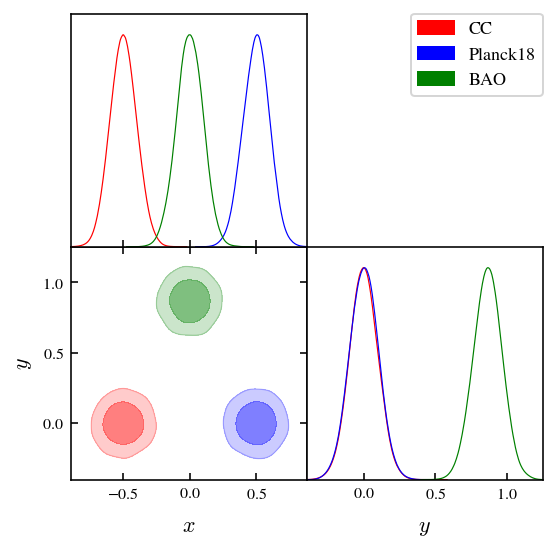

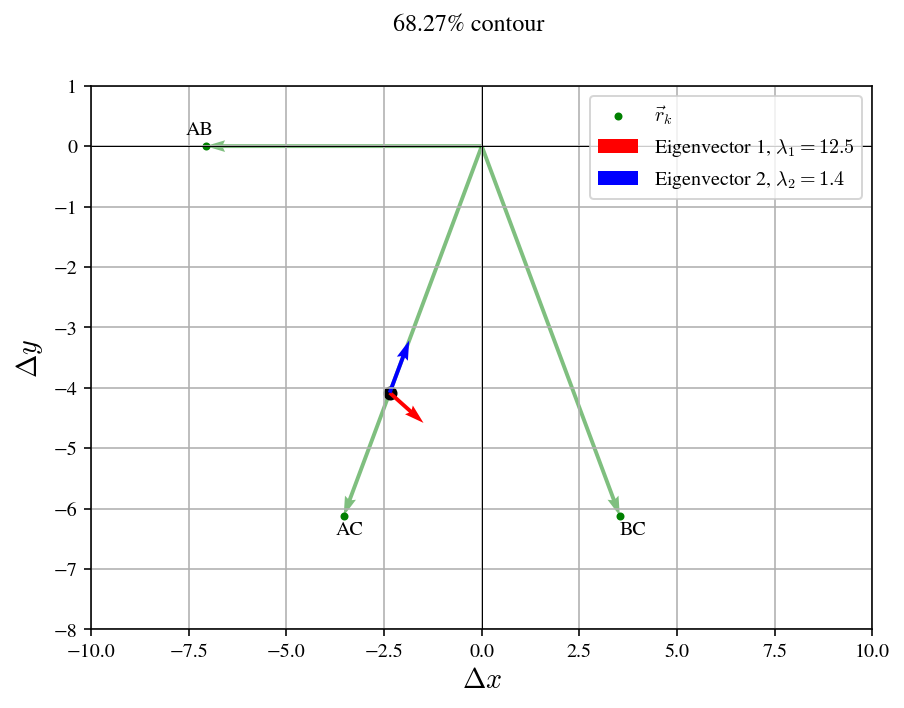

Angle between eigenvectors: 0
PTE = 1.3887943864963998e-11
$N_\sigma_Q^123$ = 6.75907


PTE = 1.3887943864963998e-11
$N_\sigma_Q^126$ = 6.75907


PTE = 1.0
$N_\sigma_Q^153$ = -0


PTE = 1.3887943864963998e-11
$N_\sigma_Q^156$ = 6.75907


PTE = 1.3887943864963998e-11
$N_\sigma_Q1 (AB)$ = 6.75907


PTE = 1.3887943864963998e-11
$N_\sigma_Q2 (AC)$ = 6.75907


PTE = 1.3887943864963998e-11
$N_\sigma_Q3 (BC)$ = 6.75907


In [6]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

# Example usage:
C_123= construct_C(np.array([r_1, r_2, r_3]))
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C_123)

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [7]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}


latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 1.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 6.7591 \\
$N_\sigma^{126}$ & 6.7591 \\
$N_\sigma^{153}$ & -0.0000 \\
$N_\sigma^{156}$ & 6.7591 \\
$N_\sigma^{1}$ & 6.7591 \\
$N_\sigma^{2}$ & 6.7591 \\
$N_\sigma^{3}$ & 6.7591 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 1.}
\label{tab:nsigma_values}
\end{table}


Center of mass 123: [-1.05409255 -1.82574186]
Center of mass 126: [-2.10818511  0.        ]
Center of mass 153: [0. 0.]
Center of mass 156: [-1.05409255  1.82574186]


Norm of CM 123: 2.1081851067789197
Norm of CM 126: 2.1081851067789197
Norm of CM 153: 0.0
Norm of CM 156: 2.1081851067789197


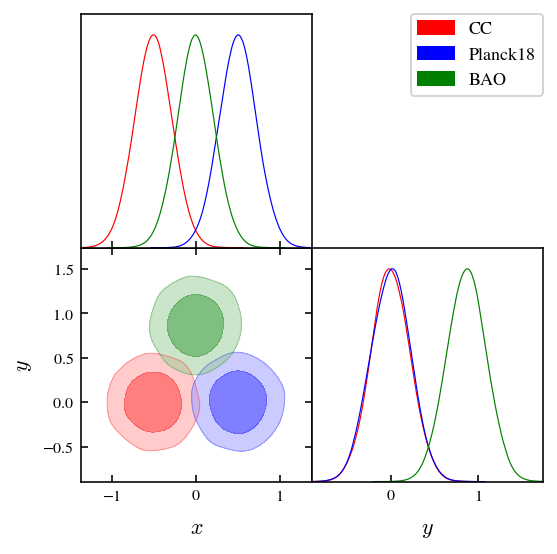

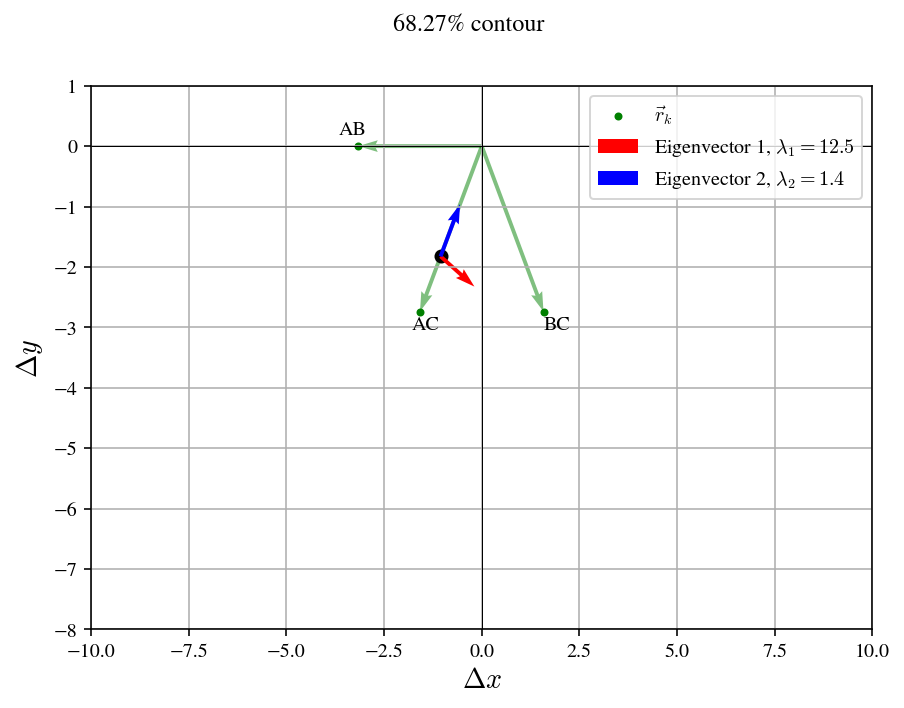

Angle between eigenvectors: 0
PTE = 0.00673794699908546
$N_\sigma_Q^123$ = 2.70953


PTE = 0.00673794699908546
$N_\sigma_Q^126$ = 2.70953


PTE = 1.0
$N_\sigma_Q^153$ = -0


PTE = 0.00673794699908546
$N_\sigma_Q^156$ = 2.70953


PTE = 0.00673794699908546
$N_\sigma_Q1 (AB)$ = 2.70953


PTE = 0.00673794699908546
$N_\sigma_Q2 (AC)$ = 2.70953


PTE = 0.00673794699908546
$N_\sigma_Q3 (BC)$ = 2.70953


In [8]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 5*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [9]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}


latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 1.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 2.7095 \\
$N_\sigma^{126}$ & 2.7095 \\
$N_\sigma^{153}$ & -0.0000 \\
$N_\sigma^{156}$ & 2.7095 \\
$N_\sigma^{1}$ & 2.7095 \\
$N_\sigma^{2}$ & 2.7095 \\
$N_\sigma^{3}$ & 2.7095 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 1.}
\label{tab:nsigma_values}
\end{table}


Center of mass 123: [-1.36082763  0.        ]
Center of mass 126: [-2.72165527  0.        ]
Center of mass 153: [0. 0.]
Center of mass 156: [-1.36082763  0.        ]


Norm of CM 123: 1.3608276348795432
Norm of CM 126: 2.721655269759087
Norm of CM 153: 0.0
Norm of CM 156: 1.3608276348795434


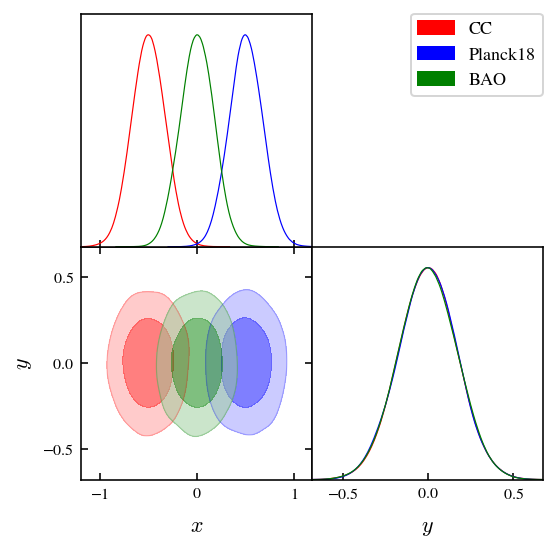

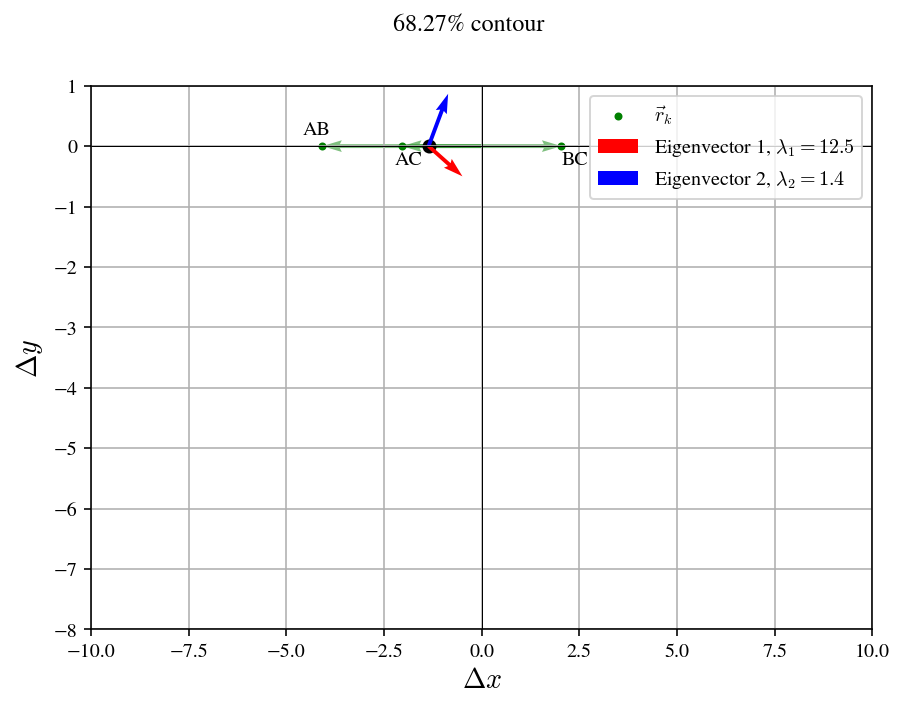

Angle between eigenvectors: 0
PTE = 0.1245144714441231
$N_\sigma_Q^123$ = 1.5361


PTE = 0.00024036947641951404
$N_\sigma_Q^126$ = 3.67231


PTE = 1.0
$N_\sigma_Q^153$ = -0


PTE = 0.12451447144412299
$N_\sigma_Q^156$ = 1.5361


PTE = 0.00024036947641951404
$N_\sigma_Q1 (AB)$ = 3.67231


PTE = 0.12451447144412299
$N_\sigma_Q2 (AC)$ = 1.5361


PTE = 0.12451447144412299
$N_\sigma_Q3 (BC)$ = 1.5361


In [10]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = 3*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

C_123 = construct_C(np.array([r_1, r_2, r_3]))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors


PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [11]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}


latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 1.5.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 1.5361 \\
$N_\sigma^{126}$ & 3.6723 \\
$N_\sigma^{153}$ & -0.0000 \\
$N_\sigma^{156}$ & 1.5361 \\
$N_\sigma^{1}$ & 3.6723 \\
$N_\sigma^{2}$ & 1.5361 \\
$N_\sigma^{3}$ & 1.5361 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 1.5.}
\label{tab:nsigma_values}
\end{table}


Center of mass 123: [-1.51374715  0.        ]
Center of mass 126: [-3.18041382  0.        ]
Center of mass 153: [-0.15291952  0.        ]
Center of mass 156: [-1.81958618  0.        ]


Norm of CM 123: 1.5137471507731053
Norm of CM 126: 3.180413817439772
Norm of CM 153: 0.1529195158935616
Norm of CM 156: 1.8195861825602282


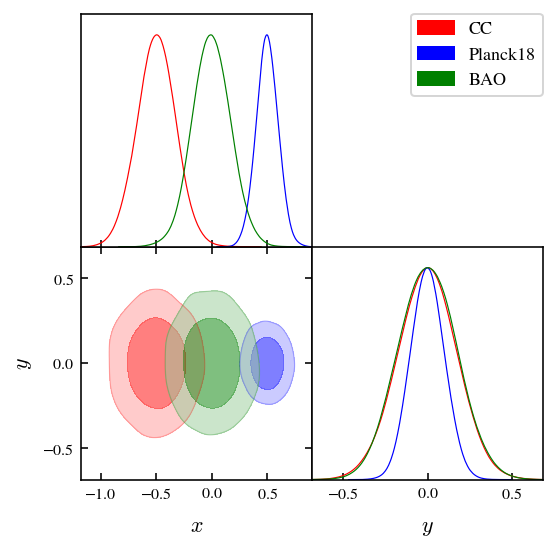

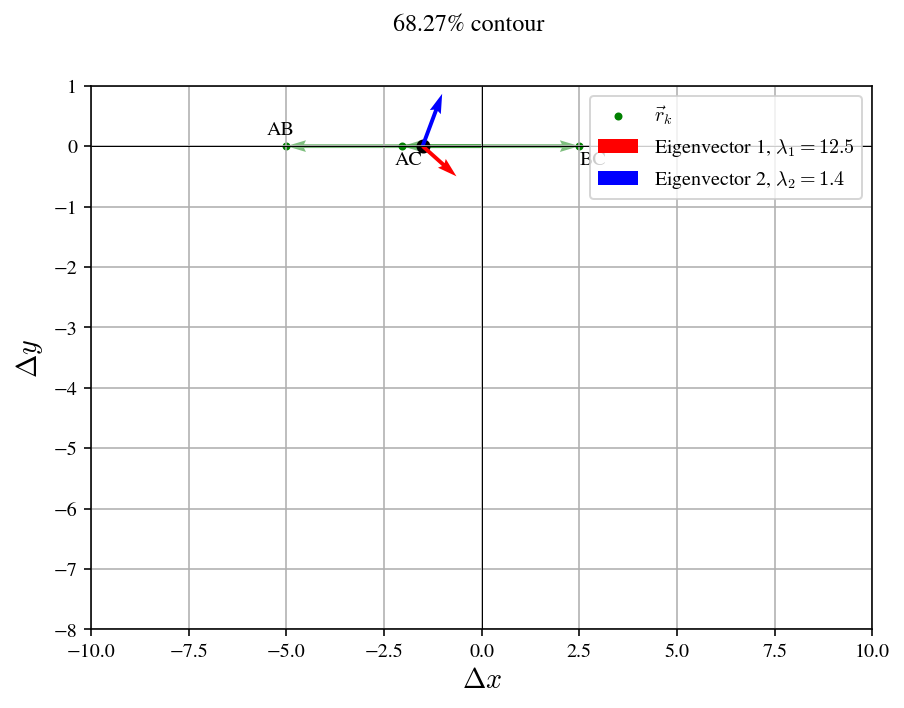

Angle between eigenvectors: 0
PTE = 0.07593639165580421
$N_\sigma_Q^123$ = 1.77477


PTE = 1.1428377326375789e-05
$N_\sigma_Q^126$ = 4.38822


PTE = 0.9740356000640706
$N_\sigma_Q^153$ = 0.0325473


PTE = 0.024118994141925327
$N_\sigma_Q^156$ = 2.25523


PTE = 3.7266531720786718e-06
$N_\sigma_Q1 (AB)$ = 4.62607


PTE = 0.12451447144412299
$N_\sigma_Q2 (AC)$ = 1.5361


PTE = 0.04393693362340742
$N_\sigma_Q3 (BC)$ = 2.01469


In [12]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = 3*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()/3
cov_C = cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

C_123 = construct_C(np.array([r_1, r_2, r_3]))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors


PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

Center of mass 123: [-1.36082763  0.        ]
Center of mass 126: [-3.0274943  0.       ]
Center of mass 153: [0.30583903 0.        ]
Center of mass 156: [-1.36082763  0.        ]


Norm of CM 123: 1.3608276348795434
Norm of CM 126: 3.0274943015462106
Norm of CM 153: 0.3058390317871232
Norm of CM 156: 1.3608276348795434


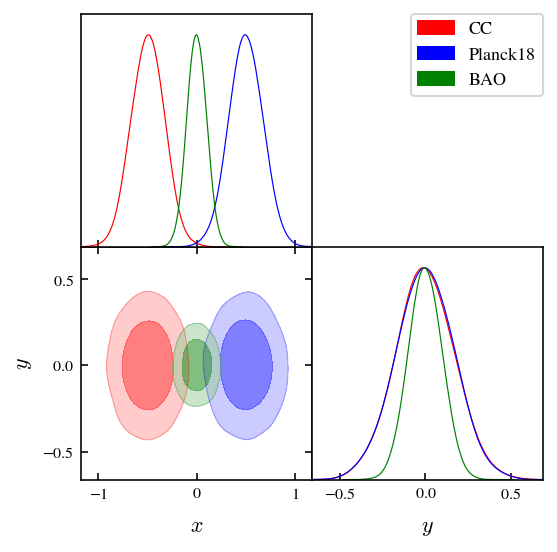

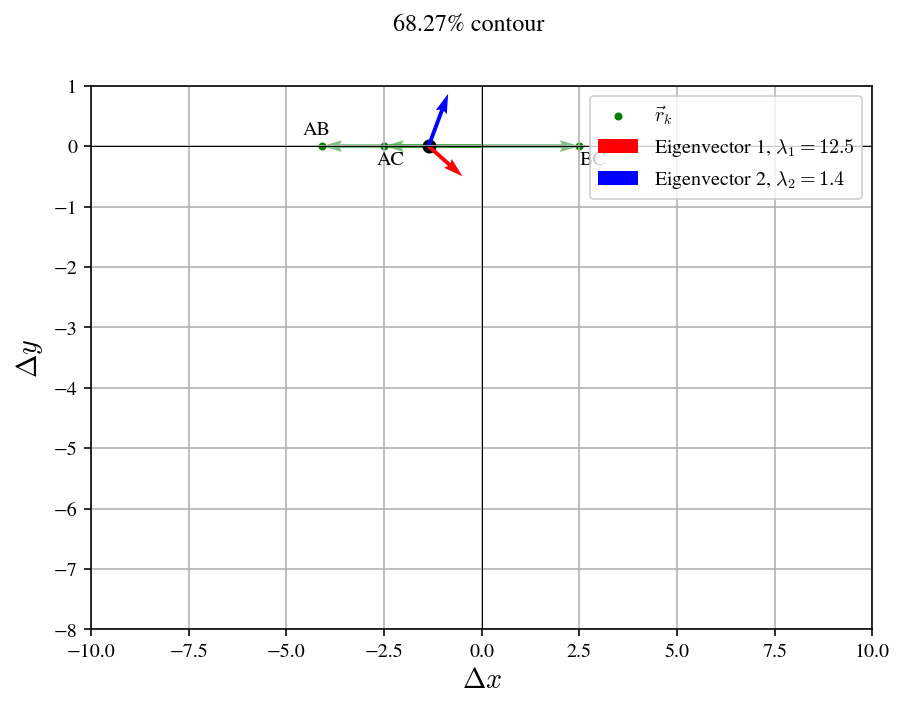

Angle between eigenvectors: 0
PTE = 0.12451447144412299
$N_\sigma_Q^123$ = 1.5361


PTE = 3.325062599469131e-05
$N_\sigma_Q^126$ = 4.14998


PTE = 0.9001177395112713
$N_\sigma_Q^153$ = 0.125513


PTE = 0.12451447144412299
$N_\sigma_Q^156$ = 1.5361


PTE = 0.00024036947641951404
$N_\sigma_Q1 (AB)$ = 3.67231


PTE = 0.04393693362340742
$N_\sigma_Q2 (AC)$ = 2.01469


PTE = 0.04393693362340742
$N_\sigma_Q3 (BC)$ = 2.01469


In [13]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = 3*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()/3

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

C_123 = construct_C(np.array([r_1, r_2, r_3]))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors


PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

# Case 2

Center of mass 123: [-0.23570226 -0.40824829]
Center of mass 126: [-0.47140452  0.        ]
Center of mass 153: [0. 0.]
Center of mass 156: [-0.23570226  0.40824829]


Norm of CM 123: 0.47140452079103173
Norm of CM 126: 0.47140452079103173
Norm of CM 153: 0.0
Norm of CM 156: 0.47140452079103173


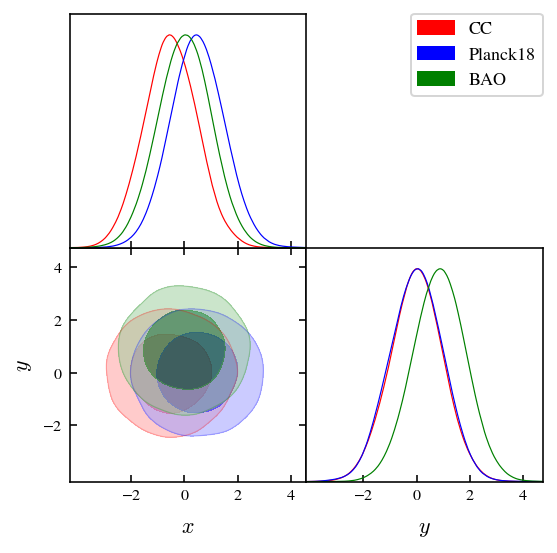

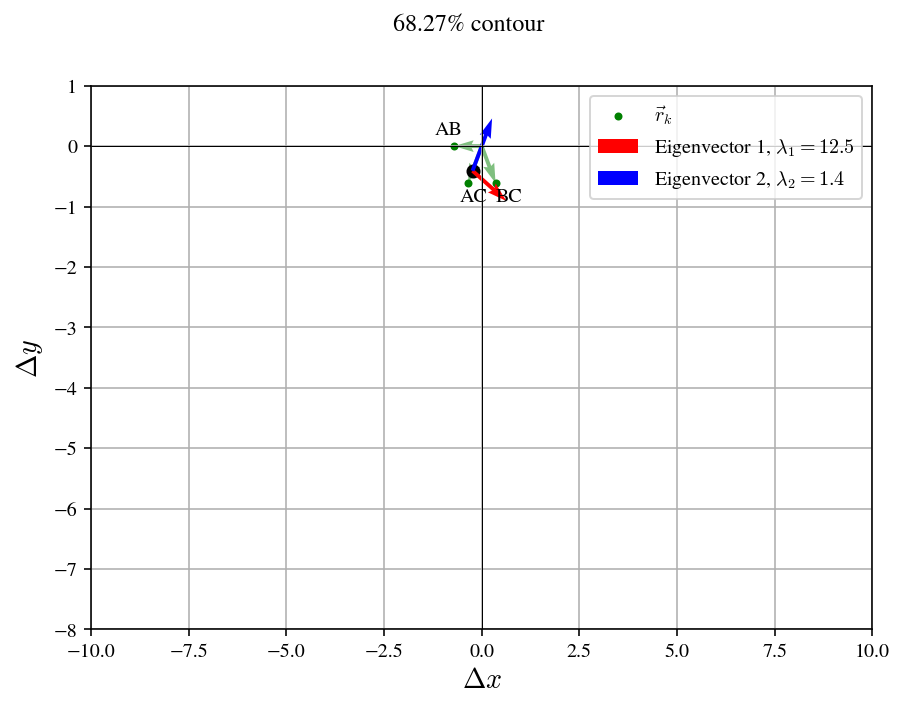

Angle between eigenvectors: 0
PTE = 0.7788007830714048
$N_\sigma_Q^123$ = 0.280882


PTE = 0.7788007830714048
$N_\sigma_Q^126$ = 0.280882


PTE = 1.0
$N_\sigma_Q^153$ = -0


PTE = 0.7788007830714048
$N_\sigma_Q^156$ = 0.280882


PTE = 0.7788007830714048
$N_\sigma_Q1 (AB)$ = 0.280882


PTE = 0.7788007830714048
$N_\sigma_Q2 (AC)$ = 0.280882


PTE = 0.7788007830714048
$N_\sigma_Q3 (BC)$ = 0.280882


In [14]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 100*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors


PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [15]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}


latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 2.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 0.2809 \\
$N_\sigma^{126}$ & 0.2809 \\
$N_\sigma^{153}$ & -0.0000 \\
$N_\sigma^{156}$ & 0.2809 \\
$N_\sigma^{1}$ & 0.2809 \\
$N_\sigma^{2}$ & 0.2809 \\
$N_\sigma^{3}$ & 0.2809 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 2.}
\label{tab:nsigma_values}
\end{table}


# Case 3

Center of mass 123: [-0.37966746 -0.49136664]
Center of mass 126: [-0.61536973 -0.08311835]
Center of mass 153: [-0.0479884   0.08311835]
Center of mass 156: [-0.28369066  0.49136664]


Norm of CM 123: 0.6209577754210713
Norm of CM 126: 0.6209577754210712
Norm of CM 153: 0.09597680300781385
Norm of CM 156: 0.5673813237988455


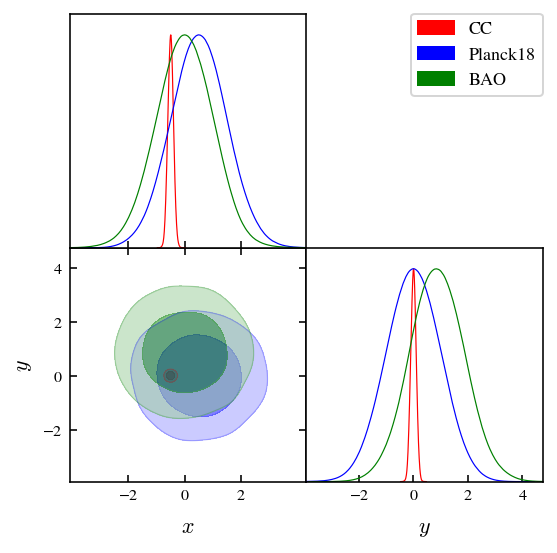

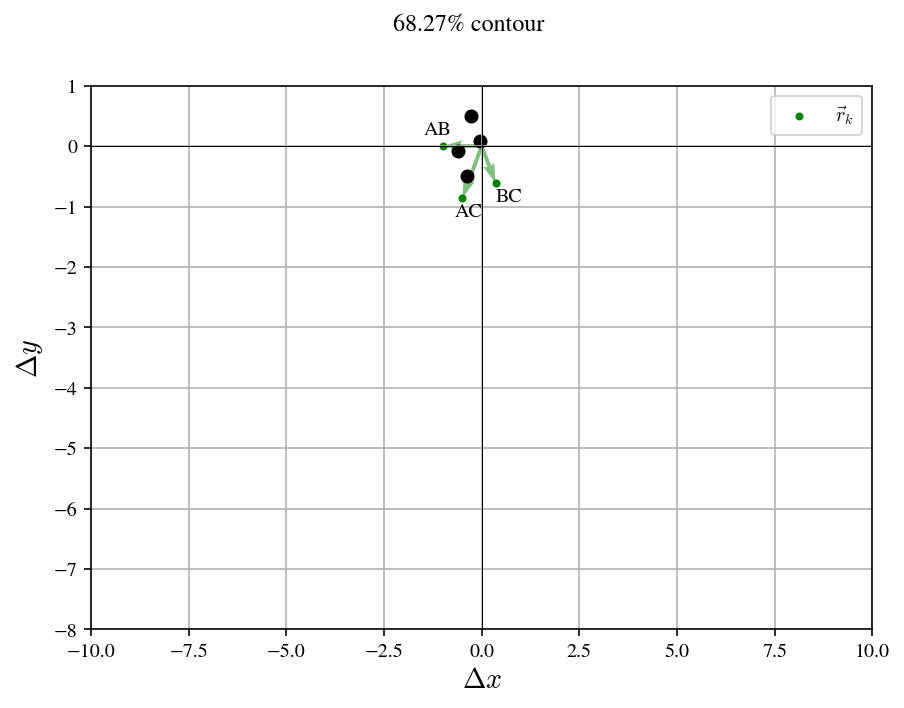

$N_\sigma_Q^123$ = 0.575889
$N_\sigma_Q^126$ = 0.575505
$N_\sigma_Q^153$ = 0.281522
$N_\sigma_Q^156$ = 0.281522


PTE = 0.609540731265658
$N_\sigma_Q1 (AB)$ = 0.510729


PTE = 0.609540731265658
$N_\sigma_Q2 (AC)$ = 0.510729


PTE = 0.7788007830714048
$N_\sigma_Q3 (BC)$ = 0.280882


In [16]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
#samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')
ax.scatter([R_CM_126[0]], [R_CM_126[1]], color='black')#, label='CM')
ax.scatter([R_CM_153[0]], [R_CM_153[1]], color='black')#, label='CM')
ax.scatter([R_CM_156[0]], [R_CM_156[1]], color='black')#, label='CM')

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()



N_sigma_123, N_sigma_126, N_sigma_153, N_sigma_156 = Q_tot_3data(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, num_samples=int(1e5))
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [17]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}

latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 3.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 0.5759 \\
$N_\sigma^{126}$ & 0.5755 \\
$N_\sigma^{153}$ & 0.2815 \\
$N_\sigma^{156}$ & 0.2815 \\
$N_\sigma^{1}$ & 0.5107 \\
$N_\sigma^{2}$ & 0.5107 \\
$N_\sigma^{3}$ & 0.2809 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 3.}
\label{tab:nsigma_values}
\end{table}


# Case 4

Center of mass 123: [-2.3570226  -0.57448499]
Center of mass 126: [-2.68870167  0.        ]
Center of mass 153: [-2.02534354  0.        ]
Center of mass 156: [-2.3570226   0.57448499]


Norm of CM 123: 2.426023198334238
Norm of CM 126: 2.6887016673584885
Norm of CM 153: 2.0253435405518285
Norm of CM 156: 2.426023198334238


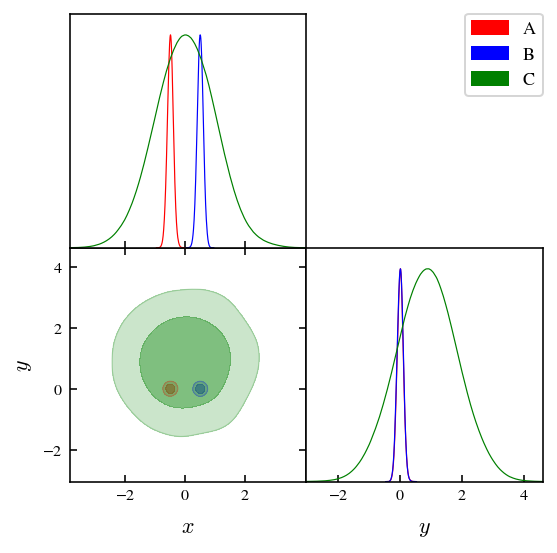

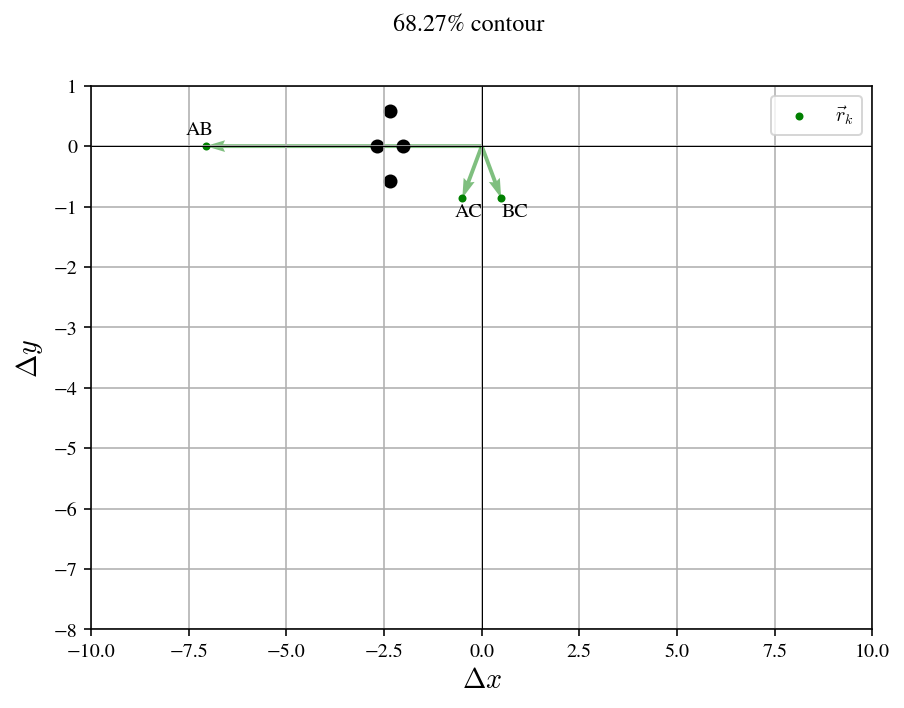

$N_\sigma_Q^123$ = 2.80943
$N_\sigma_Q^126$ = inf
$N_\sigma_Q^153$ = inf
$N_\sigma_Q^156$ = 2.82096


PTE = 1.3887943864963998e-11
$N_\sigma_Q1 (AB)$ = 6.75907


PTE = 0.609540731265658
$N_\sigma_Q2 (AC)$ = 0.510729


PTE = 0.609540731265658
$N_\sigma_Q3 (BC)$ = 0.510729


In [18]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['A', 'B', 'C'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
#samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')
ax.scatter([R_CM_126[0]], [R_CM_126[1]], color='black')#, label='CM')
ax.scatter([R_CM_153[0]], [R_CM_153[1]], color='black')#, label='CM')
ax.scatter([R_CM_156[0]], [R_CM_156[1]], color='black')#, label='CM')

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

N_sigma_123, N_sigma_126, N_sigma_153, N_sigma_156 = Q_tot_3data(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, num_samples = int(1e6))
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')

In [19]:
# Crear una tabla en formato LaTeX con los valores de N_sigma
N_sigma_values = {
    "$N_\sigma^{123}$": N_sigma_123,
    "$N_\sigma^{126}$": N_sigma_126,
    "$N_\sigma^{153}$": N_sigma_153,
    "$N_\sigma^{156}$": N_sigma_156,
    "$N_\sigma^{1}$": n_sigma_1,
    "$N_\sigma^{2}$": n_sigma_2,
    "$N_\sigma^{3}$": n_sigma_3,
}

latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|c|}\n\\hline\n"
latex_table += "Variable & Valor \\\\\n\\hline\n"

for key, value in N_sigma_values.items():
    latex_table += f"{key} & {value:.4f} \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Valores de $N_\\sigma$ para el caso 4.}\n\\label{tab:nsigma_values}\n\\end{table}"

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Variable & Valor \\
\hline
$N_\sigma^{123}$ & 2.8094 \\
$N_\sigma^{126}$ & inf \\
$N_\sigma^{153}$ & inf \\
$N_\sigma^{156}$ & 2.8210 \\
$N_\sigma^{1}$ & 6.7591 \\
$N_\sigma^{2}$ & 0.5107 \\
$N_\sigma^{3}$ & 0.5107 \\
\hline
\end{tabular}
\caption{Valores de $N_\sigma$ para el caso 4.}
\label{tab:nsigma_values}
\end{table}


# Real data

In [20]:
import git
import sys, os

d = 2
L = 6  # Number of vector


# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared parameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


In [21]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))
r_7 = - r_1
r_8 = - r_2
r_9 = - r_3
r_10 = - r_4
r_11 = - r_5
r_12 = - r_6
print('r_1: {}'.format(r_1))
print('r_2: {}'.format(r_2))
print('r_3: {}'.format(r_3))
print('r_4: {}'.format(r_4))
print('r_5: {}'.format(r_5))
print('r_6: {}'.format(r_6))

r_1: [0.72499108 0.11187943]
r_2: [-0.57096539 -1.56939903]
r_3: [-0.18195025 -2.04095555]
r_4: [-2.57218121 -1.94067629]
r_5: [-2.86721793 -6.08786704]
r_6: [-1.26927411  0.43165239]


In [22]:

# Example usage:
R_CM_1 = calculate_R_CM(np.array([r_1, r_2, r_3, r_4, r_5, r_6]))
R_CM_2 = calculate_R_CM(np.array([r_1, r_2, r_3, r_4, r_5, r_12]))
R_CM_3 = calculate_R_CM(np.array([r_1, r_2, r_3, r_4, r_11, r_6]))
R_CM_4 = calculate_R_CM(np.array([r_1, r_2, r_3, r_4, r_11, r_12]))

R_CM_5 = calculate_R_CM(np.array([r_1, r_2, r_3, r_10, r_5, r_6]))
R_CM_6 = calculate_R_CM(np.array([r_1, r_2, r_3, r_10, r_5, r_12]))
R_CM_7 = calculate_R_CM(np.array([r_1, r_2, r_3, r_10, r_11, r_6]))
R_CM_8 = calculate_R_CM(np.array([r_1, r_2, r_3, r_10, r_11, r_12]))

R_CM_9 = calculate_R_CM(np.array([r_1, r_2, r_9, r_4, r_5, r_6]))
R_CM_10 = calculate_R_CM(np.array([r_1, r_2, r_9, r_4, r_5, r_12]))
R_CM_11 = calculate_R_CM(np.array([r_1, r_2, r_9, r_4, r_11, r_6]))
R_CM_12 = calculate_R_CM(np.array([r_1, r_2, r_9, r_4, r_11, r_12]))

R_CM_13 = calculate_R_CM(np.array([r_1, r_2, r_9, r_10, r_5, r_6]))
R_CM_14 = calculate_R_CM(np.array([r_1, r_2, r_9, r_10, r_5, r_12]))
R_CM_15 = calculate_R_CM(np.array([r_1, r_2, r_9, r_10, r_11, r_6]))
R_CM_16 = calculate_R_CM(np.array([r_1, r_2, r_9, r_10, r_11, r_12]))

R_CM_17 = calculate_R_CM(np.array([r_1, r_8, r_3, r_4, r_5, r_6]))
R_CM_18 = calculate_R_CM(np.array([r_1, r_8, r_3, r_4, r_5, r_12]))
R_CM_19 = calculate_R_CM(np.array([r_1, r_8, r_3, r_4, r_11, r_6]))
R_CM_20 = calculate_R_CM(np.array([r_1, r_8, r_3, r_4, r_11, r_12]))

R_CM_21 = calculate_R_CM(np.array([r_1, r_8, r_3, r_10, r_5, r_6]))
R_CM_22 = calculate_R_CM(np.array([r_1, r_8, r_3, r_10, r_5, r_12]))
R_CM_23 = calculate_R_CM(np.array([r_1, r_8, r_3, r_10, r_11, r_6]))
R_CM_24 = calculate_R_CM(np.array([r_1, r_8, r_3, r_10, r_11, r_12]))

R_CM_25 = calculate_R_CM(np.array([r_1, r_8, r_9, r_4, r_5, r_6]))
R_CM_26 = calculate_R_CM(np.array([r_1, r_8, r_9, r_4, r_5, r_12]))
R_CM_27 = calculate_R_CM(np.array([r_1, r_8, r_9, r_4, r_11, r_6]))
R_CM_28 = calculate_R_CM(np.array([r_1, r_8, r_9, r_4, r_11, r_12]))

R_CM_29 = calculate_R_CM(np.array([r_1, r_8, r_9, r_10, r_5, r_6]))
R_CM_30 = calculate_R_CM(np.array([r_1, r_8, r_9, r_10, r_5, r_12]))
R_CM_31 = calculate_R_CM(np.array([r_1, r_8, r_9, r_10, r_11, r_6]))
R_CM_32 = calculate_R_CM(np.array([r_1, r_8, r_9, r_10, r_11, r_12]))

print('Center of mass 1: {}'.format(R_CM_1))
print('Center of mass 2: {}'.format(R_CM_2))
print('Center of mass 3: {}'.format(R_CM_3))
print('Center of mass 4: {}'.format(R_CM_4))
print('Center of mass 5: {}'.format(R_CM_5))
print('Center of mass 6: {}'.format(R_CM_6))
print('Center of mass 7: {}'.format(R_CM_7))
print('Center of mass 8: {}'.format(R_CM_8))
print('Center of mass 9: {}'.format(R_CM_9))
print('Center of mass 10: {}'.format(R_CM_10))
print('Center of mass 11: {}'.format(R_CM_11))
print('Center of mass 12: {}'.format(R_CM_12))
print('Center of mass 13: {}'.format(R_CM_13))
print('Center of mass 14: {}'.format(R_CM_14))
print('Center of mass 15: {}'.format(R_CM_15))
print('Center of mass 16: {}'.format(R_CM_16))
print('Center of mass 17: {}'.format(R_CM_17))  
print('Center of mass 18: {}'.format(R_CM_18))
print('Center of mass 19: {}'.format(R_CM_19))
print('Center of mass 20: {}'.format(R_CM_20))
print('Center of mass 21: {}'.format(R_CM_21))  
print('Center of mass 22: {}'.format(R_CM_22))
print('Center of mass 23: {}'.format(R_CM_23))
print('Center of mass 24: {}'.format(R_CM_24))
print('Center of mass 25: {}'.format(R_CM_25))
print('Center of mass 26: {}'.format(R_CM_26))
print('Center of mass 27: {}'.format(R_CM_27))
print('Center of mass 28: {}'.format(R_CM_28))
print('Center of mass 29: {}'.format(R_CM_29))
print('Center of mass 30: {}'.format(R_CM_30))
print('Center of mass 31: {}'.format(R_CM_31))
print('Center of mass 32: {}'.format(R_CM_32))

print('\n')
print('Norm of CM 1: {}'.format(np.linalg.norm(R_CM_1)))
print('Norm of CM 2: {}'.format(np.linalg.norm(R_CM_2)))
print('Norm of CM 3: {}'.format(np.linalg.norm(R_CM_3)))
print('Norm of CM 4: {}'.format(np.linalg.norm(R_CM_4)))
print('Norm of CM 5: {}'.format(np.linalg.norm(R_CM_5)))
print('Norm of CM 6: {}'.format(np.linalg.norm(R_CM_6)))
print('Norm of CM 7: {}'.format(np.linalg.norm(R_CM_7)))
print('Norm of CM 8: {}'.format(np.linalg.norm(R_CM_8)))
print('Norm of CM 9: {}'.format(np.linalg.norm(R_CM_9)))
print('Norm of CM 10: {}'.format(np.linalg.norm(R_CM_10)))
print('Norm of CM 11: {}'.format(np.linalg.norm(R_CM_11)))
print('Norm of CM 12: {}'.format(np.linalg.norm(R_CM_12)))
print('Norm of CM 13: {}'.format(np.linalg.norm(R_CM_13)))
print('Norm of CM 14: {}'.format(np.linalg.norm(R_CM_14)))
print('Norm of CM 15: {}'.format(np.linalg.norm(R_CM_15)))
print('Norm of CM 16: {}'.format(np.linalg.norm(R_CM_16)))
print('Norm of CM 17: {}'.format(np.linalg.norm(R_CM_17)))
print('Norm of CM 18: {}'.format(np.linalg.norm(R_CM_18)))
print('Norm of CM 19: {}'.format(np.linalg.norm(R_CM_19)))
print('Norm of CM 20: {}'.format(np.linalg.norm(R_CM_20)))
print('Norm of CM 21: {}'.format(np.linalg.norm(R_CM_21)))
print('Norm of CM 22: {}'.format(np.linalg.norm(R_CM_22)))
print('Norm of CM 23: {}'.format(np.linalg.norm(R_CM_23)))
print('Norm of CM 24: {}'.format(np.linalg.norm(R_CM_24)))
print('Norm of CM 25: {}'.format(np.linalg.norm(R_CM_25)))
print('Norm of CM 26: {}'.format(np.linalg.norm(R_CM_26)))
print('Norm of CM 27: {}'.format(np.linalg.norm(R_CM_27)))
print('Norm of CM 28: {}'.format(np.linalg.norm(R_CM_28)))
print('Norm of CM 29: {}'.format(np.linalg.norm(R_CM_29)))
print('Norm of CM 30: {}'.format(np.linalg.norm(R_CM_30)))
print('Norm of CM 31: {}'.format(np.linalg.norm(R_CM_31)))
print('Norm of CM 32: {}'.format(np.linalg.norm(R_CM_32)))

Center of mass 1: [-1.1227663  -1.84922768]
Center of mass 2: [-0.69967493 -1.99311181]
Center of mass 3: [-0.16702699  0.18006133]
Center of mass 4: [0.25606438 0.0361772 ]
Center of mass 5: [-0.26537257 -1.20233559]
Center of mass 6: [ 0.1577188  -1.34621971]
Center of mass 7: [0.69036675 0.82695343]
Center of mass 8: [1.11345812 0.6830693 ]
Center of mass 9: [-1.06211622 -1.16890917]
Center of mass 10: [-0.63902485 -1.31279329]
Center of mass 11: [-0.10637691  0.86037985]
Center of mass 12: [0.31671446 0.71649572]
Center of mass 13: [-0.20472248 -0.52201707]
Center of mass 14: [ 0.21836889 -0.6659012 ]
Center of mass 15: [0.75101683 1.50727194]
Center of mass 16: [1.1741082  1.36338781]
Center of mass 17: [-0.93244451 -1.32609467]
Center of mass 18: [-0.50935314 -1.4699788 ]
Center of mass 19: [0.0232948  0.70319434]
Center of mass 20: [0.44638617 0.55931021]
Center of mass 21: [-0.07505077 -0.67920257]
Center of mass 22: [ 0.3480406 -0.8230867]
Center of mass 23: [0.88068854 1.3500

In [23]:
def ensure_positive_first_component(vectors):
    """
    Toma una lista de vectores y devuelve una nueva lista donde la primera componente
    de cada vector es positiva. Si la primera componente es negativa, se multiplica el vector por -1.
    
    Parameters:
        vectors (list of numpy.ndarray): Lista de vectores.
    
    Returns:
        list of numpy.ndarray: Lista de vectores con la primera componente positiva.
    """
    return [vector if vector[0] >= 0 else -vector for vector in vectors]


vectors_list = [r_1, r_2, r_3, r_4, r_5, r_6]
# Ejemplo de uso:
adjusted_vectors = ensure_positive_first_component(vectors_list)
print(adjusted_vectors)
# Identificar cuáles vectores se cambiaron de signo
changed_sign = [i for i, vector in enumerate(vectors_list) if vector[0] < 0]

# Mostrar los índices de los vectores que se cambiaron de signo
print(f"Vectores que se cambiaron de signo: {changed_sign}")

[array([0.72499108, 0.11187943]), array([0.57096539, 1.56939903]), array([0.18195025, 2.04095555]), array([2.57218121, 1.94067629]), array([2.86721793, 6.08786704]), array([ 1.26927411, -0.43165239])]
Vectores que se cambiaron de signo: [1, 2, 3, 4, 5]


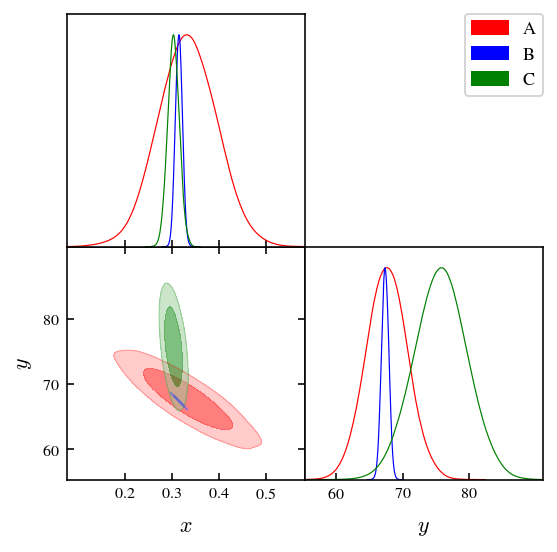

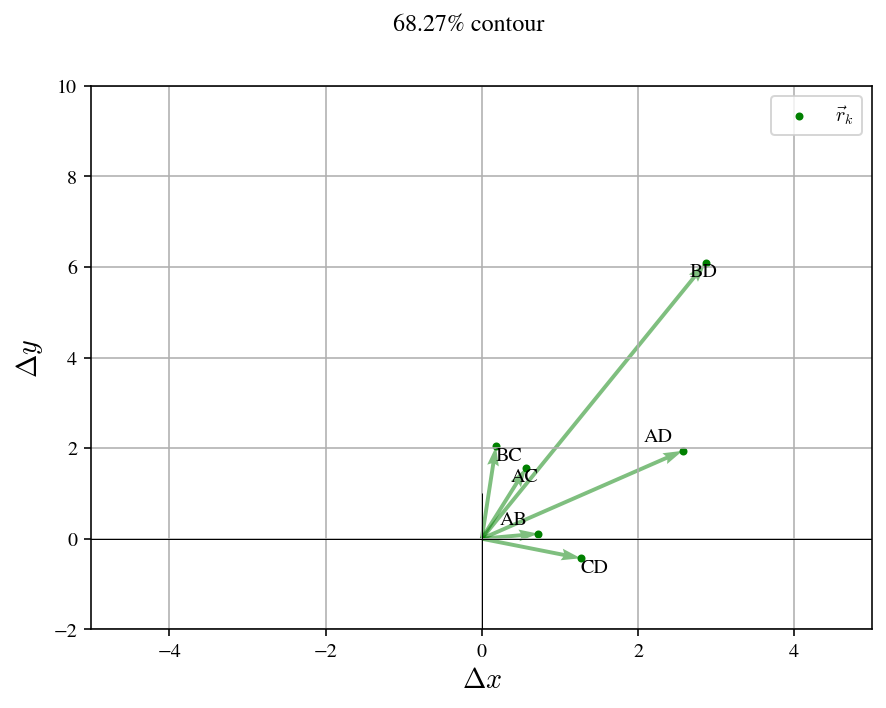

$N_\sigma_Q$ = inf


PTE = 0.7640939447242219
$N_\sigma_Q1 (AB)$ = 0.300109


PTE = 0.24795514987175957
$N_\sigma_Q2 (AC)$ = 1.15533


PTE = 0.12254184468920325
$N_\sigma_Q3 (BC)$ = 1.54419


PTE = 0.005565489646257141
$N_\sigma_Q4 (AD)$ = 2.77234


PTE = 1.4686139544362586e-10
$N_\sigma_Q5 (BD)$ = 6.4086


PTE = 0.4071025030304751
$N_\sigma_Q6 (CD)$ = 0.829003


In [24]:
samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['A', 'B', 'C'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
#samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_8[0], r_8[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_9[0], r_9[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_10[0], r_10[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_11[0], r_11[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_12[0], r_12[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_8[0], r_9[0], r_10[0], r_11[0], r_12[0]], [r_1[1], r_8[1], r_9[1], r_10[1], r_11[1], r_12[1]],
            marker='.',color='green', label=r'$\vec{r}_{k}$')

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_8[0]-0.2, r_8[1]-0.3, 'AC')
ax.text(r_9[0]-0.0, r_9[1]-0.3, 'BC')
ax.text(r_10[0]-0.5, r_10[1]+0.2, 'AD')
ax.text(r_11[0]-0.2, r_11[1]-0.3, 'BD')
ax.text(r_12[0]-0.0, r_12[1]-0.3, 'CD')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

#ax.set_xlim(*lim_x)
#ax.set_ylim(*lim_y)

ax.set_xlim(-5, 5)
ax.set_ylim(-2, 10)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

N_sigma = Q_tot_4data(mean_A, mean_B, mean_C, mean_D, cov_A, cov_B, cov_C, cov_D, num_samples = int(1e5))
print(f'$N_\sigma_Q$ = {N_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_4)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q4 (AD)$ = {n_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_5)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q5 (BD)$ = {n_sigma:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_6)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q6 (CD)$ = {n_sigma:2g}')


In [ ]:
import git
import sys, os

d = 2
L = 3  # Number of vector


# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: Planck18 
B: BAO 
C: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared parameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)



Center of mass 123: [-1.43948076 -2.5657234 ]
Center of mass 126: [-0.59329802 -2.85349166]
Center of mass 153: [0.47199786 1.49285463]
Center of mass 156: [1.3181806  1.20508637]


Norm of CM 123: 2.941945177575331
Norm of CM 126: 2.9145183441644753
Norm of CM 153: 1.5656937474134702
Norm of CM 156: 1.7860104263766357


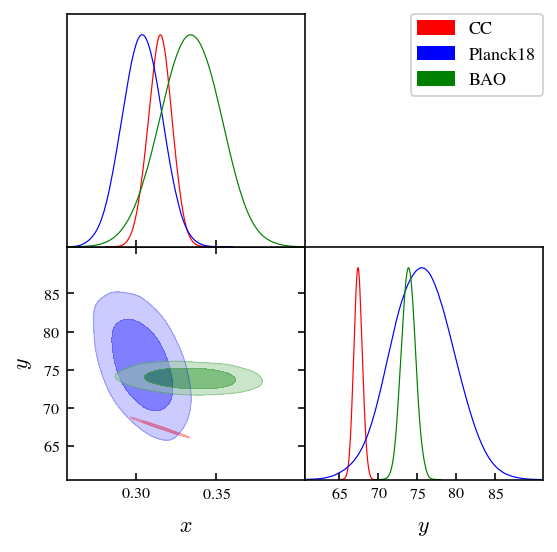

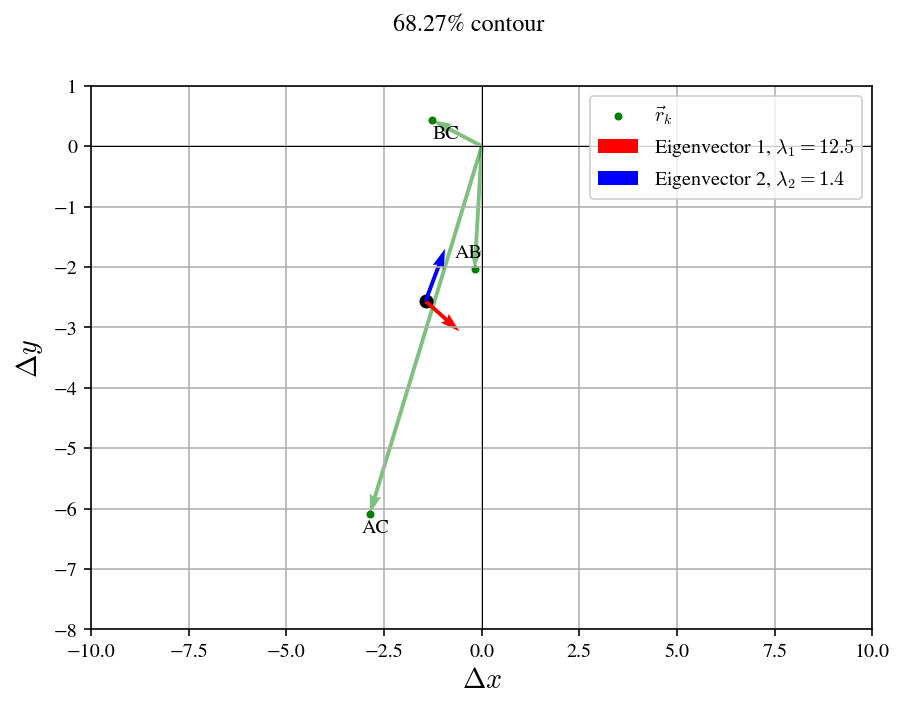

Angle between eigenvectors: 0
PTE = 5.9062071583986105e-05
$N_\sigma_Q^123$ = 4.01653


PTE = 7.075981339852291e-05
$N_\sigma_Q^126$ = 3.97372


PTE = 0.0634297982174704
$N_\sigma_Q^153$ = 1.85617


PTE = 0.027638034356377926
$N_\sigma_Q^156$ = 2.20239


PTE = 0.12254184468920325
$N_\sigma_Q1 (AB)$ = 1.54419


PTE = 1.4686139544362586e-10
$N_\sigma_Q2 (AC)$ = 6.4086


PTE = 0.4071025030304751
$N_\sigma_Q3 (BC)$ = 0.829003


In [26]:
# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

print('Center of mass 123: {}'.format(R_CM_123))
print('Center of mass 126: {}'.format(R_CM_126))
print('Center of mass 153: {}'.format(R_CM_153))
print('Center of mass 156: {}'.format(R_CM_156))
print('\n')
print('Norm of CM 123: {}'.format(np.linalg.norm(R_CM_123)))
print('Norm of CM 126: {}'.format(np.linalg.norm(R_CM_126)))
print('Norm of CM 153: {}'.format(np.linalg.norm(R_CM_153)))
print('Norm of CM 156: {}'.format(np.linalg.norm(R_CM_156)))

C_123 = construct_C(np.array([r_1, r_2, r_3]))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:2g}% contour'.format(probabilidad*100))

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM_123[0], R_CM_123[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
ax.text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:2g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors


PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_123)**2)
N_sigma_123 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{123}$ = {N_sigma_123:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_126)**2)
N_sigma_126 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{126}$ = {N_sigma_126:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_153)**2)
N_sigma_153 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{153}$ = {N_sigma_153:2g}')

print('\n')

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM_156)**2)
N_sigma_156 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q^{156}$ = {N_sigma_156:2g}')


print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_1)**2)
n_sigma_1 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q1 (AB)$ = {n_sigma_1:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_2)**2)
n_sigma_2 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q2 (AC)$ = {n_sigma_2:2g}')

print('\n')

PTE = chi2(d).sf(np.linalg.norm(r_3)**2)
n_sigma_3 = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q3 (BC)$ = {n_sigma_3:2g}')